# MLP Exercise - fantasy name generation

In [48]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from src.layers import Linear, BatchNorm1d, LayerNorm1d, Tanh, Dropout

import glob
import pandas as pd 

%matplotlib inline

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    # Clear any existing CUDA cache
    torch.cuda.empty_cache()
    print(f"Cleared CUDA cache")


Using device: cuda
GPU: NVIDIA GeForce RTX 5060
Memory: 7.96 GB
Cleared CUDA cache


In [49]:
# Get the datasets

import kagglehub

# Download latest version
path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [50]:
def normalize_string_df(df, column = 0):
    series = (df[column].str.normalize('NFKD')
                   .str.encode('ascii', errors='ignore')
                   .str.decode('utf-8')
                   .str.lower()
                   .str.replace(r'[^\w\s]', '')
                   .str.replace(r'\d+', '', regex=True)
                   .str.replace('/', '')
                   .str.replace('(', '')
                   .str.replace(')', '')
                   .str.replace('"', "'")
                   .str.replace('_', ' ')
                   .str.replace('`', "'")
                   .str.replace('.', "")
                   .str.strip()
                   )
    return series

In [51]:
# clean data, normalize strings 
names = []
categories = []
for f in glob.glob(path+"/*.csv"):#  + ["./names_clean.csv", "./forgotten_realms_inhabitants_by_race.csv"]:
    df = pd.read_csv(f, header=None)
    series = normalize_string_df(df)
    names.append(series)
    import re
    match = re.search(r'\\\w*.csv', f)
    if match:
        categories.append([match.group(0).replace("\\", "").replace(".csv", "")] * len(series))
    else:
        print(f"(no csv filename found in: {f})")

# Adding names from names_clean.csv
words = pd.concat(names).to_list()
categories = [cat for sublist in categories for cat in sublist]


In [52]:
f2 = pd.read_csv("./forgotten_realms_inhabitants_by_race.csv")
series2 = normalize_string_df(f2, "name")
categories2 = f2["source_category"].str.replace("Category: ", "")
words.extend(series2)
categories.extend(categories2)


In [53]:
print(len(words))
words[:8]

# Debug: Check what characters are actually in the processed words
print(f"\n{'='*60}")
print("CHARACTER ANALYSIS")
print(f"{'='*60}")
all_chars_in_words = set()
for w in words:
  all_chars_in_words.update(w)

  # build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

print(f"Total unique characters in processed words: {len(all_chars_in_words)}")
print(f"Characters in vocabulary (stoi): {len(stoi)}")
print(f"\nCharacters in words but NOT in vocabulary:")
missing_from_vocab = all_chars_in_words - set(stoi.keys())
if missing_from_vocab:
  for ch in sorted(missing_from_vocab):
    print(f"  '{ch}' (ord={ord(ch)}, repr={repr(ch)})")
else:
  print("  ✓ All characters are in vocabulary")

print(f"\nCharacters in vocabulary but NOT in words:")
extra_in_vocab = set(stoi.keys()) - all_chars_in_words
if extra_in_vocab:
  for ch in sorted(extra_in_vocab):
    print(f"  '{ch}' (ord={ord(ch)}, repr={repr(ch)})")
else:
  print("  ✓ All vocabulary characters appear in words")

# Check for empty strings
empty_count = sum(1 for w in words if not w or len(w.strip()) == 0)
print(f"\nEmpty strings found: {empty_count}")
if empty_count > 0:
  print("  ⚠️  WARNING: Empty strings will cause issues!")
  empty_examples = [w for w in words[:100] if not w or len(w.strip()) == 0]
  print(f"  First few empty examples: {empty_examples[:10]}")

print(f"{'='*60}\n")

41221

CHARACTER ANALYSIS
{1: ' ', 2: "'", 3: ',', 4: '-', 5: 'a', 6: 'b', 7: 'c', 8: 'd', 9: 'e', 10: 'f', 11: 'g', 12: 'h', 13: 'i', 14: 'j', 15: 'k', 16: 'l', 17: 'm', 18: 'n', 19: 'o', 20: 'p', 21: 'q', 22: 'r', 23: 's', 24: 't', 25: 'u', 26: 'v', 27: 'w', 28: 'x', 29: 'y', 30: 'z', 0: '.'}
31
Total unique characters in processed words: 30
Characters in vocabulary (stoi): 31

Characters in words but NOT in vocabulary:
  ✓ All characters are in vocabulary

Characters in vocabulary but NOT in words:
  '.' (ord=46, repr='.')

Empty strings found: 0



In [54]:
# Build category vocabulary
print(f"\n{'='*60}")
print("CATEGORY ANALYSIS")
print(f"{'='*60}")

# Normalize category names (lowercase, remove "Category:" prefix if present)
normalized_categories = []
for cat in categories:
    if pd.isna(cat) or cat == "":
        normalized_categories.append("unknown")
    else:
        # Remove "Category:" prefix and normalize
        cat_clean = str(cat).lower().replace("category:", "").strip()
        normalized_categories.append(cat_clean if cat_clean else "unknown")

# Create category vocabulary
unique_categories = sorted(list(set(normalized_categories)))
cat_stoi = {cat: i for i, cat in enumerate(unique_categories)}
cat_itos = {i: cat for cat, i in cat_stoi.items()}
cat_vocab_size = len(cat_stoi)

print(f"Total unique categories: {cat_vocab_size}")
print(f"Sample categories: {list(unique_categories[:10])}")
print(f"Category vocabulary size: {cat_vocab_size}")

# Verify alignment: words and categories should have same length
assert len(words) == len(normalized_categories), f"Mismatch: {len(words)} words vs {len(normalized_categories)} categories"
print(f"✓ Words and categories aligned: {len(words)} samples")
print(f"{'='*60}\n")


CATEGORY ANALYSIS
Total unique categories: 596
Sample categories: ['aarakocra', 'aasimar', 'abbalayar', 'aboleths', 'abominations', 'administrator genies', 'air elementals', 'alaghi', 'alhoons', 'allips']
Category vocabulary size: 596
✓ Words and categories aligned: 41221 samples



In [55]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?
g = torch.Generator().manual_seed(2147483647) # for reproducibility

def build_dataset(words, word_categories):  
  X, Y, C = [], [], []  # C for category indices
  
  # Debug: Track problematic words
  missing_chars = set()
  empty_words = []
  problematic_words = []
  
  for idx, w in enumerate(words):
    # Check for empty strings
    if not w or len(w.strip()) == 0:
      empty_words.append((idx, w))
      continue
    
    # Get category for this word
    cat = word_categories[idx] if idx < len(word_categories) else "unknown"
    cat_idx = cat_stoi.get(cat, cat_stoi.get("unknown", 0))
    
    context = [0] * block_size
    word_chars = []
    
    try:
      for ch in w + '.':
        if ch not in stoi:
          missing_chars.add(ch)
          problematic_words.append((idx, w, f"Missing char: '{ch}' (ord={ord(ch)})"))
          raise KeyError(f"Character '{ch}' not in stoi")
        ix = stoi[ch]
        word_chars.append((ch, ix))
        X.append(context.copy())
        Y.append(ix)
        C.append(cat_idx)  # Same category for all positions in this word
        context = context[1:] + [ix] # crop and append
    except KeyError as e:
      # Skip this word but continue processing
      if len(problematic_words) <= 10:  # Only print first 10
        print(f"  ERROR at word {idx}: '{w}' - {e}")
      continue
  
  # Print debugging info
  if missing_chars:
    print(f"\n⚠️  Found {len(missing_chars)} missing characters:")
    for ch in sorted(missing_chars):
      print(f"    '{ch}' (ord={ord(ch)}, repr={repr(ch)})")
  
  if empty_words:
    print(f"\n⚠️  Found {len(empty_words)} empty words (first 10):")
    for idx, w in empty_words[:10]:
      print(f"    Index {idx}: {repr(w)}")
  
  if problematic_words:
    print(f"\n⚠️  Found {len(problematic_words)} problematic words (first 10):")
    for idx, w, reason in problematic_words[:10]:
      print(f"    Index {idx}: '{w}' - {reason}")
  
  if not missing_chars and not empty_words and not problematic_words:
    print("✓ All words processed successfully")

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  C = torch.tensor(C)  # Category indices
  print(X.shape, Y.shape, C.shape)
  return X, Y, C

import random
# Create pairs of (word, category) for shuffling together
word_cat_pairs = list(zip(words, normalized_categories))
random.seed(42)
random.shuffle(word_cat_pairs)
words_shuffled, categories_shuffled = zip(*word_cat_pairs)
words_shuffled = list(words_shuffled)
categories_shuffled = list(categories_shuffled)

n1 = int(0.95*len(words_shuffled))
n2 = int(0.98*len(words_shuffled))

Xtr,  Ytr,  Ctr  = build_dataset(words_shuffled[:n1], categories_shuffled[:n1])     # 95%
Xdev, Ydev, Cdev = build_dataset(words_shuffled[n1:n2], categories_shuffled[n1:n2])   # 3%
Xte,  Yte,  Cte  = build_dataset(words_shuffled[n2:], categories_shuffled[n2:])     # 2%

# Keep dataset on CPU - only move batches to GPU during training (saves GPU memory)
print(f"Dataset kept on CPU (saves GPU memory)")
print(f"  Training samples: {len(Xtr)}")
print(f"  Validation samples: {len(Xdev)}")
print(f"  Test samples: {len(Xte)}")
print(f"  Category vocabulary size: {cat_vocab_size}")


✓ All words processed successfully
torch.Size([381273, 16]) torch.Size([381273]) torch.Size([381273])
✓ All words processed successfully
torch.Size([12268, 16]) torch.Size([12268]) torch.Size([12268])
✓ All words processed successfully
torch.Size([7971, 16]) torch.Size([7971]) torch.Size([7971])
Dataset kept on CPU (saves GPU memory)
  Training samples: 381273
  Validation samples: 12268
  Test samples: 7971
  Category vocabulary size: 596


In [56]:
n_embd = 64 # the dimensionality of the character embedding vectors
n_hidden = 256 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Self-Attention layer class (single head)
class SelfAttention:
  def __init__(self, n_embd, head_size, block_size, dropout=0.0):
    self.n_embd = n_embd
    self.head_size = head_size
    self.block_size = block_size
    # Create Q, K, V projection matrices
    self.key = Linear(n_embd, head_size, bias=False)
    self.query = Linear(n_embd, head_size, bias=False)
    self.value = Linear(n_embd, head_size, bias=False)
    # Output projection
    self.proj = Linear(head_size, n_embd, bias=False)
    # Layer normalization after attention to stabilize gradients
    self.ln = LayerNorm1d(n_embd)
    # Causal mask: lower triangular matrix to prevent looking at future tokens
    self.register_buffer = lambda name, val: setattr(self, name, val)
    tril = torch.tril(torch.ones(block_size, block_size, device=device))
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', tril)
    
  def __call__(self, x):
    # x shape: (batch_size, block_size, n_embd)
    B, T, C = x.shape
    
    # Compute Q, K, V
    k = self.key(x)   # (B, T, head_size)
    q = self.query(x) # (B, T, head_size)
    v = self.value(x) # (B, T, head_size)
    
    # Compute attention scores: (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
    wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # scaled dot-product
    wei = wei.masked_fill(self.mask[:T, :T] == 0, float('-inf'))  # apply causal mask
    wei = F.softmax(wei, dim=-1)  # (B, T, T)
    
    # Apply attention to values
    out = wei @ v  # (B, T, head_size)
    
    # Output projection
    out = self.proj(out)  # (B, T, n_embd)
    
    # Layer normalization to stabilize gradients and prevent NaN
    out = self.ln(out)  # (B, T, n_embd)
    out = self.dropout(out)
    self.out = out
    return out
  
  def parameters(self):
    return (self.key.parameters() + self.query.parameters() + 
            self.value.parameters() + self.proj.parameters() + 
            self.ln.parameters())

# Multi-Head Self-Attention layer class
class MultiHeadAttention:
  def __init__(self, n_embd, num_heads, head_size, block_size, dropout=0.0):
    self.n_embd = n_embd
    self.num_heads = num_heads
    self.head_size = head_size
    self.block_size = block_size
    # Create Q, K, V projection matrices for all heads at once
    # Project to num_heads * head_size, then we'll split into heads
    self.key = Linear(n_embd, num_heads * head_size, bias=False)
    self.query = Linear(n_embd, num_heads * head_size, bias=False)
    self.value = Linear(n_embd, num_heads * head_size, bias=False)
    # Output projection (concatenated heads -> n_embd)
    self.proj = Linear(num_heads * head_size, n_embd, bias=False)
    # Layer normalization after attention to stabilize gradients
    self.ln = LayerNorm1d(n_embd)
    # Causal mask: lower triangular matrix to prevent looking at future tokens
    self.register_buffer = lambda name, val: setattr(self, name, val)
    tril = torch.tril(torch.ones(block_size, block_size)).to(device)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', tril)
    
  def __call__(self, x):
    # x shape: (batch_size, block_size, n_embd)
    B, T, C = x.shape
    
    # Compute Q, K, V for all heads
    k = self.key(x)   # (B, T, num_heads * head_size)
    q = self.query(x) # (B, T, num_heads * head_size)
    v = self.value(x) # (B, T, num_heads * head_size)
    
    # Reshape to separate heads: (B, T, num_heads, head_size)
    # Then transpose to: (B, num_heads, T, head_size)
    k = k.view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, num_heads, T, head_size)
    q = q.view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, num_heads, T, head_size)
    v = v.view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, num_heads, T, head_size)
    
    # Compute attention scores for all heads in parallel
    # (B, num_heads, T, head_size) @ (B, num_heads, head_size, T) -> (B, num_heads, T, T)
    wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # scaled dot-product
    wei = wei.masked_fill(self.mask[:T, :T] == 0, float('-inf'))  # apply causal mask
    wei = F.softmax(wei, dim=-1)  # (B, num_heads, T, T)
    
    # Apply attention to values
    out = wei @ v  # (B, num_heads, T, head_size)
    
    # Concatenate heads: (B, num_heads, T, head_size) -> (B, T, num_heads * head_size)
    out = out.transpose(1, 2).contiguous().view(B, T, self.num_heads * self.head_size)
    
    # Output projection
    out = self.proj(out)  # (B, T, n_embd)
    
    # Layer normalization to stabilize gradients and prevent NaN
    out = self.ln(out)  # (B, T, n_embd)
    out = self.dropout(out)
    self.out = out
    return out
  
  def parameters(self):
    return (self.key.parameters() + self.query.parameters() + 
            self.value.parameters() + self.proj.parameters() + 
            self.ln.parameters())

# Category Cross-Attention: Category acts as query, character sequence as key/value
class CategoryCrossAttention:
  def __init__(self, cat_emb_dim, n_embd, head_size, block_size, dropout=0.0):
    self.cat_emb_dim = cat_emb_dim  # Category embedding dimension
    self.n_embd = n_embd  # Character embedding dimension
    self.head_size = head_size
    self.block_size = block_size
    # Query from category embedding
    self.cat_query = Linear(cat_emb_dim, head_size, bias=False)
    # Key and Value from character sequence
    self.seq_key = Linear(n_embd, head_size, bias=False)
    self.seq_value = Linear(n_embd, head_size, bias=False)
    # Output projection: maps back to n_embd
    self.proj = Linear(head_size, n_embd, bias=False)
    # Layer normalization
    self.ln = LayerNorm1d(n_embd)
    self.dropout = nn.Dropout(dropout)
    
  def __call__(self, x, cat_emb):
    # x: (batch_size, block_size, n_embd) - character sequence
    # cat_emb: (batch_size, cat_emb_dim) - category embedding
    B, T, C = x.shape
    
    # Query from category (single vector per batch)
    q = self.cat_query(cat_emb)  # (B, head_size)
    q = q.unsqueeze(1)  # (B, 1, head_size) - expand to sequence length
    
    # Key and Value from character sequence
    k = self.seq_key(x)   # (B, T, head_size)
    v = self.seq_value(x) # (B, T, head_size)
    
    # Compute attention: category queries sequence
    # (B, 1, head_size) @ (B, head_size, T) -> (B, 1, T)
    wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # scaled dot-product
    wei = F.softmax(wei, dim=-1)  # (B, 1, T)
    
    # Apply attention to values: category attends to sequence
    # (B, 1, T) @ (B, T, head_size) -> (B, 1, head_size)
    out = wei @ v  # (B, 1, head_size)
    
    # Expand to sequence length: broadcast category-conditioned representation
    out = out.expand(B, T, self.head_size)  # (B, T, head_size)
    
    # Output projection
    out = self.proj(out)  # (B, T, n_embd)
    
    # Layer normalization
    out = self.ln(out)  # (B, T, n_embd)
    out = self.dropout(out)
    self.out = out
    return out
  
  def parameters(self):
    return (self.cat_query.parameters() + self.seq_key.parameters() + 
            self.seq_value.parameters() + self.proj.parameters() + 
            self.ln.parameters())


# Wrapper for CategoryCrossAttention that stores category embeddings
# This allows it to work in the layers list
class CategoryCrossAttentionWrapper:
  def __init__(self, cross_attention_layer):
    self.cross_attention = cross_attention_layer
    self.cat_emb = None  # Will be set before forward pass
    
  def set_category_embeddings(self, cat_emb):
    """Set category embeddings for this batch"""
    self.cat_emb = cat_emb
    
  def __call__(self, x):
    # x is 3D: (batch, seq_len, embd)
    if self.cat_emb is None:
      raise RuntimeError("Category embeddings not set! Call set_category_embeddings() first.")
    # Category cross-attention: category queries sequence
    x_cat = self.cross_attention(x, self.cat_emb)  # (batch, seq_len, embd)
    # Add residual connection: combine original sequence with category-conditioned output
    x = x + x_cat  # Residual connection
    self.out = x
    return x
  
  def parameters(self):
    return self.cross_attention.parameters()


C = torch.randn((vocab_size, n_embd),            generator=g)
# Category embedding table
cat_emb_dim = 32  # Category embedding dimension
C_cat = torch.randn((cat_vocab_size, cat_emb_dim), generator=g)
# Create linear layer to transform embeddings before attention
# This will transform from n_embd to n_hidden dimension
linear_pre_attention = Linear(n_embd, n_hidden, bias=False)

# Multi-head attention configuration
num_heads = 8  # Number of attention heads
head_size = n_hidden // num_heads  # Each head processes head_size dimensions
# Ensure head_size * num_heads equals n_hidden
assert n_hidden % num_heads == 0, f"n_hidden ({n_hidden}) must be divisible by num_heads ({num_heads})"

# Category cross-attention: category queries character sequence
cat_cross_attn = CategoryCrossAttention(cat_emb_dim, n_hidden, n_hidden, block_size, 0.1)
cat_cross_attn_wrapper = CategoryCrossAttentionWrapper(cat_cross_attn)

# Choose attention type:
# Option 1: Single-head attention (original)
# attention = SelfAttention(n_hidden, n_hidden, block_size, 0.1)

# Option 2: Multi-head attention (recommended for better representation)
attention1 = MultiHeadAttention(n_hidden, num_heads, head_size, block_size, 0.1)
attention2 = MultiHeadAttention(n_hidden, num_heads, head_size, block_size, 0.1)
attention3 = MultiHeadAttention(n_hidden, num_heads, head_size, block_size, 0.1)
attention4 = MultiHeadAttention(n_hidden, num_heads, head_size, block_size, 0.1)
attention5 = MultiHeadAttention(n_hidden, num_heads, head_size, block_size, 0.1)

# Wrapper class to apply linear layer to 3D input (position-wise)
# Applies linear transformation to each position independently
class Linear3D:
  def __init__(self, linear_layer):
    self.linear = linear_layer
    
  def __call__(self, x):
    # x is 3D: (batch, seq_len, in_dim)
    B, T, C = x.shape
    # Reshape to 2D: (batch * seq_len, in_dim)
    x = x.view(B * T, C)
    # Apply linear layer
    x = self.linear(x)  # (batch * seq_len, out_dim)
    # Reshape back to 3D: (batch, seq_len, out_dim)
    x = x.view(B, T, -1)
    self.out = x
    return x
  
  def parameters(self):
    return self.linear.parameters()

# Wrapper class for attention that keeps 3D shape (for stacking multiple attention layers)
class Attention3D:
  def __init__(self, attention_layer):
    self.attention = attention_layer
    
  def __call__(self, x):
    # x is 3D: (batch, seq_len, embd)
    x = self.attention(x)  # (batch, seq_len, embd) - stays 3D
    self.out = x
    return x
  
  def parameters(self):
    return self.attention.parameters()

# Wrapper class to integrate attention into layers list
# Handles 3D -> 2D conversion (attention outputs 3D, MLP expects 2D)
class AttentionFlatten:
  def __init__(self, attention_layer):
    self.attention = attention_layer
    
  def __call__(self, x):
    # x is 3D: (batch, seq_len, embd)
    x = self.attention(x)  # (batch, seq_len, embd)
    # Flatten to 2D: (batch, seq_len * embd)
    x = x.view(x.shape[0], -1)
    self.out = x 
    return x
  
  def parameters(self):
    return self.attention.parameters()

layers = [
  Linear3D(linear_pre_attention),  # Transform embeddings: (batch, seq_len, n_embd) -> (batch, seq_len, n_hidden)
  cat_cross_attn_wrapper,  # Category cross-attention: category queries sequence
  Attention3D(attention1),  # attention layer: (batch, seq_len, n_hidden) -> (batch, seq_len, n_hidden)
  Attention3D(attention2),  # attention layer: (batch, seq_len, n_hidden) -> (batch, seq_len, n_hidden)
  Attention3D(attention3),  # attention layer: (batch, seq_len, n_hidden) -> (batch, seq_len, n_hidden)
  Attention3D(attention4),  # attention layer: (batch, seq_len, n_hidden) -> (batch, seq_len, n_hidden)
  AttentionFlatten(attention5),  # Third attention + LayerNorm + Flatten: (batch, seq_len, n_hidden) -> (batch, seq_len * n_hidden)
  Linear(n_hidden * block_size, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), LayerNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C, C_cat] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Move all parameters to GPU
C = C.to(device)
C_cat = C_cat.to(device)
for p in parameters:
  p.data = p.data.to(device)

# Move all attention masks to GPU
for layer in layers:
  if hasattr(layer, 'attention') and hasattr(layer.attention, 'mask'):
    layer.attention.mask = layer.attention.mask.to(device)

print(f"Moved {sum(p.nelement() for p in parameters)} parameters to {device}")

# Check GPU memory usage after moving parameters
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB, Total: {total:.2f} GB")
    print(f"Available: {total - reserved:.2f} GB")

2613118
Moved 2613118 parameters to cuda
GPU Memory - Allocated: 0.01 GB, Reserved: 0.03 GB, Total: 8.55 GB
Available: 8.52 GB


In [57]:
# same optimization as last time
max_steps = 300000
batch_size = 128  
lossi = []
ud = []

# Clear any previous GPU errors and check memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    # Reset CUDA error state if any
    try:
        torch.cuda.synchronize()
    except:
        print("Warning: GPU had previous error state - consider restarting kernel")
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    print(f"Before training - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")

# Comprehensive data validation and debugging
print(f"\n{'='*60}")
print(f"DATASET VALIDATION & DEBUGGING")
print(f"{'='*60}")
print(f"Vocab size: {vocab_size}")
print(f"Vocab chars: {sorted(stoi.keys())}")
print(f"\nDataset shapes:")
print(f"  Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"  Xdev: {Xdev.shape}, Ydev: {Ydev.shape}")
print(f"  Xte: {Xte.shape}, Yte: {Yte.shape}")

# Check for NaN values
print(f"\nChecking for NaN values:")
x_nan = torch.isnan(Xtr).any().item()
y_nan = torch.isnan(Ytr).any().item()
print(f"  Xtr has NaN: {x_nan}")
print(f"  Ytr has NaN: {y_nan}")
if x_nan or y_nan:
  print("  ⚠️  WARNING: NaN values found!")

# Check for invalid indices
print(f"\nChecking index ranges:")
x_min, x_max = Xtr.min().item(), Xtr.max().item()
y_min, y_max = Ytr.min().item(), Ytr.max().item()
print(f"  Xtr min/max: {x_min}/{x_max} (valid: 0-{vocab_size-1})")
print(f"  Ytr min/max: {y_min}/{y_max} (valid: 0-{vocab_size-1})")

if x_max >= vocab_size:
  print(f"  ⚠️  ERROR: Xtr has invalid indices >= vocab_size!")
  invalid_x = (Xtr >= vocab_size).nonzero(as_tuple=True)
  print(f"  Found {len(invalid_x[0])} invalid X indices")
  if len(invalid_x[0]) > 0:
    print(f"  First 10 invalid positions: {invalid_x[0][:10].tolist()}")

if y_max >= vocab_size:
  print(f"  ⚠️  ERROR: Ytr has invalid indices >= vocab_size!")
  invalid_y = (Ytr >= vocab_size).nonzero(as_tuple=True)
  print(f"  Found {len(invalid_y[0])} invalid Y indices")
  if len(invalid_y[0]) > 0:
    print(f"  First 10 invalid positions: {invalid_y[0][:10].tolist()}")

# Check for negative indices
if x_min < 0:
  print(f"  ⚠️  WARNING: Xtr has negative indices!")
if y_min < 0:
  print(f"  ⚠️  WARNING: Ytr has negative indices!")

# Sample some data to verify encoding
print(f"\nSample data verification (first 5 training samples):")
for i in range(min(5, len(Xtr))):
  x_seq = Xtr[i].tolist()
  y_val = Ytr[i].item()
  x_str = ''.join(['.' if tok == 0 else (itos[tok] if tok in itos else f'<{tok}>') for tok in x_seq])
  y_str = '.' if y_val == 0 else (itos[y_val] if y_val in itos else f'<{y_val}>')
  print(f"  [{i}] X: {x_str} -> Y: {y_str} (idx={y_val})")

# Final assertions
print(f"\n{'='*60}")
assert Xtr.max() < vocab_size, f"Xtr has invalid indices >= vocab_size ({vocab_size})"
assert Ytr.max() < vocab_size, f"Ytr has invalid indices >= vocab_size ({vocab_size})"
assert Xtr.min() >= 0, f"Xtr has negative indices"
assert Ytr.min() >= 0, f"Ytr has negative indices"
assert not torch.isnan(Xtr).any(), "Xtr contains NaN values"
assert not torch.isnan(Ytr).any(), "Ytr contains NaN values"
print("✓ All data validation checks passed!")
print(f"{'='*60}\n")

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  # Move only the batch to GPU (dataset stays on CPU)
  Xb, Yb, Cb = Xtr[ix].to(device), Ytr[ix].to(device), Ctr[ix].to(device) # batch X,Y,C
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors: (batch_size, block_size, n_embd)
  
  # Embed categories: get category embedding for each sample in batch
  # Cb is (batch_size,) - category indices for each sample
  # We need one category embedding per sample (not per position)
  cat_emb = C_cat[Cb]  # (batch_size, cat_emb_dim)
  
  # Set category embeddings in the cross-attention wrapper
  cat_cross_attn_wrapper.set_category_embeddings(cat_emb)
  
  # Pass through all layers (attention + normalization are now in the layers list)
  x = emb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  layers[2].attention.out.retain_grad()  # Store attention output gradient (first self-attention)
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Ensure all gradients are on GPU (in case any were computed on CPU)
  for p in parameters:
    if p.grad is not None:
      p.grad = p.grad.to(device)
  
  # update
  lr = 0.2 if i < 150000 else 0.02 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if torch.cuda.is_available():
      allocated = torch.cuda.memory_allocated(0) / 1e9
      reserved = torch.cuda.memory_reserved(0) / 1e9
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f} | GPU Mem: {allocated:.2f}GB/{reserved:.2f}GB')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

Before training - Allocated: 0.01 GB, Reserved: 0.03 GB

DATASET VALIDATION & DEBUGGING
Vocab size: 31
Vocab chars: [' ', "'", ',', '-', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Dataset shapes:
  Xtr: torch.Size([381273, 16]), Ytr: torch.Size([381273])
  Xdev: torch.Size([12268, 16]), Ydev: torch.Size([12268])
  Xte: torch.Size([7971, 16]), Yte: torch.Size([7971])

Checking for NaN values:
  Xtr has NaN: False
  Ytr has NaN: False

Checking index ranges:
  Xtr min/max: 0/30 (valid: 0-30)
  Ytr min/max: 0/30 (valid: 0-30)

Sample data verification (first 5 training samples):
  [0] X: ................ -> Y: t (idx=24)
  [1] X: ...............t -> Y: e (idx=9)
  [2] X: ..............te -> Y: g (idx=11)
  [3] X: .............teg -> Y: a (idx=5)
  [4] X: ............tega -> Y: n (idx=18)

✓ All data validation checks passed!

      0/ 300000: 3.4134 | GPU Mem: 0.13GB/0.21GB
  10000/ 300000: 2.5257

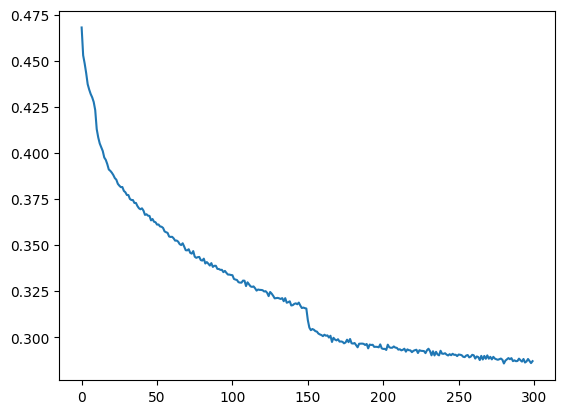

In [58]:

#plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

d:\dev\namegens\namegens\.env\Lib\site-packages\IPython\core\events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
d:\dev\namegens\namegens\.env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


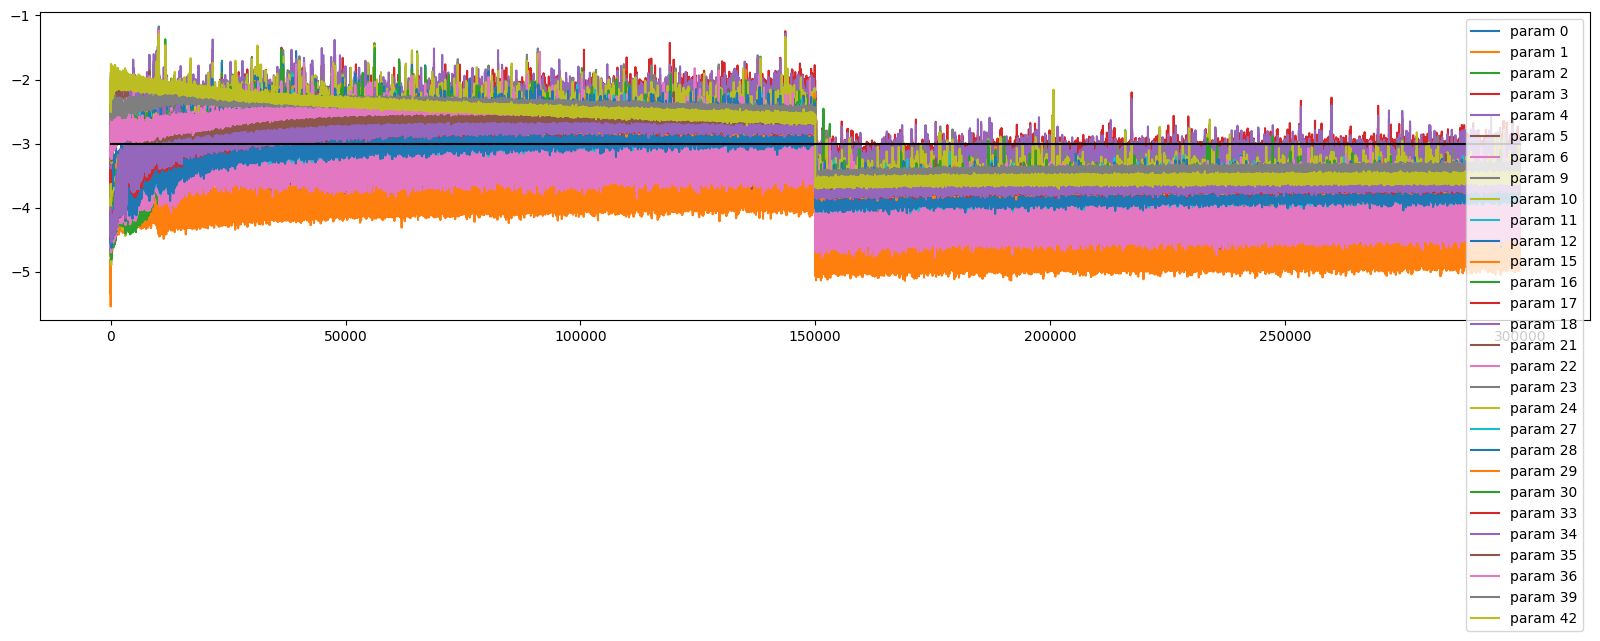

In [59]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [60]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Move batch to GPU (dataset stays on CPU)
  x, y = x.to(device), y.to(device)
  emb = C[x] # (N, block_size, n_embd)
  
  # Pass through all layers (attention + normalization are now in the layers list)
  x = emb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
# split_loss('train')
split_loss('val')

RuntimeError: The size of tensor a (128) must match the size of tensor b (12268) at non-singleton dimension 0

In [63]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 22)

for _ in range(25):
    # Pick a random category for this generation
    random_cat_idx = torch.randint(0, cat_vocab_size, (1,), generator=g, device=device).item()
    random_cat_name = cat_itos[random_cat_idx]
    
    # Embed the category
    cat_emb = C_cat[torch.tensor([random_cat_idx], device=device)]  # (1, cat_emb_dim)
    
    # Set category embeddings in the cross-attention wrapper
    cat_cross_attn_wrapper.set_category_embeddings(cat_emb)
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context], device=device)] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    # Print category and generated name
    print(f"[{random_cat_name}] {''.join(itos[i] for i in out)}") # decode and print the generated word

[brown bears] rassobaal.
[crystal dragons] partsuiant.
[alaghi] gozti.
[hadozee] vastil tarrist.
[netherese] ollindr.
[dao] ravanar lyodbane.
[gold dragons] lizza.
[green dragons] airaiakaur.
[katanga] riamondogak.
[humans] shirklim fongscower.
[cambions] bugda.
[imps] frencheb.
[giff] jack.
[jackalweres] dappinaro sbirrspant.
[doppelgangers] alopio.
[gondsmen] guthir.
[fomorians] difumara.
[ponies] halfuin.
[ghostwise halflings] osma.
[earth elementals] kessanag.
[war devils] ryssil bevorqrom.
[allips] frakig.
[tieflings] bendicibraw.
[galeb duhrs] demera ghaldargu.
[shalarin] lonis phast.


In [64]:
# sample from the model forcing more words
g = torch.Generator(device=device).manual_seed(2147483647 + 42)

for _ in range(25):
    # Pick a random category for this generation
    random_cat_idx = torch.randint(0, cat_vocab_size, (1,), generator=g, device=device).item()
    random_cat_name = cat_itos[random_cat_idx]
    
    # Embed the category
    cat_emb = C_cat[torch.tensor([random_cat_idx], device=device)]  # (1, cat_emb_dim)
    
    # Set category embeddings in the cross-attention wrapper
    cat_cross_attn_wrapper.set_category_embeddings(cat_emb)
    
    has_space = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context], device=device)] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if itos[ix] == ' ':
        has_space = True
      if ix == 0:
        if has_space==False:
            ix = stoi[' ']
            has_space = True
        else:
            break
      context = context[1:] + [ix]
      out.append(ix)

    # Print category and generated name
    print(f"[{random_cat_name}] {''.join(itos[i] for i in out)}") # decode and print the generated word

[greece] clara chaw
[hell hounds] tefblouth mryedard
[medusae] kame ghaldrep
[organizations in the cavern of cloven heads] wagg ag
[slimes] daraen eb the per
[platinum dragons] jayco ionasty
[celestial paragons] pirus araungy
[nighthaunts] garrick bleder
[pseudodragons] tendric lasnrathar
[hawks] beran alder
[eladrin] malchius eamanthin
[merfolk] gatartae boston
[ankylosauruses] reuslyl dargroum
[ophidians] nikosassoba dunchor
[arcanaloths] natrel barnit
[scro] keyal marimmwing
[jagres] kimmath du'kty
[modrons] veffarl gint rakjun
[bugbears] kakkok boadga
[bone devils] tepp beipi
[fire elementals] drigayx telver
[shadow demons] oenugurv broglas
[malaugrym] zasuaro kursokios
[aboleths] gildeguth harchul
[shield dwarves] cladewson tholguuf


In [65]:
# sample from the model forcing "the"
g = torch.Generator(device=device).manual_seed(2147483647 + 67)

for _ in range(25):
    # Pick a random category for this generation
    random_cat_idx = torch.randint(0, cat_vocab_size, (1,), generator=g, device=device).item()
    random_cat_name = cat_itos[random_cat_idx]
    
    # Embed the category
    cat_emb = C_cat[torch.tensor([random_cat_idx], device=device)]  # (1, cat_emb_dim)
    
    # Set category embeddings in the cross-attention wrapper
    cat_cross_attn_wrapper.set_category_embeddings(cat_emb)
    
    has_the = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context], device=device)] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if ix == 0:
        if has_the==False:
            context = context[5:] + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
            has_the = True
            out = out + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
        else:
            break
      else:
        context = context[1:] + [ix]
        out.append(ix)

    # Print category and generated name
    print(f"[{random_cat_name}] {''.join(itos[i] for i in out)}") # decode and print the generated word

[nabassus] connaiekaballean szangruth the ketnnyr
[mephits] hum'ean the hin
[forest gnomes] aara-tiane the ion
[abominations] jar the boldager
[wereboars] velksandrax the porch
[revenants] haarhu the spich
[driders] pentre the indson
[tasloi] thoumathon the aind
[drow] jeulfur thaskniga the gszie
[xvarts] catsimlon the dinethas
[shadow dragons] evinyeph the fan
[alu-fiends] ragamic mond ch the iinch
[hook horrors] miffeth ghobl the ghaath
[werewolves] nayaam the dulk
[half-golems] diana garog the blao
[ogre giants] kassirak the moncar
[smoke drakes] heanammentharncrad the wutte er cholom
[damarans] legtan the buapu
[half-dragons] vekelantharilla naront the w
[aspects of chauntea] ashrelle evitar the on
[desert centaurs] aabrex the botpootine cl
[deep dragons] cristina ralichil the lah
[ormyrr] nogy the oi
[blade golems] slaffl'hfar cojgs the boos
[desert centaurs] nylindo the rist


In [76]:
# sample from the model forcing more words using the category "elves"
g = torch.Generator(device=device).manual_seed(2147483647 + 42)

elves_cat_name = "elves"
# Find the index corresponding to "elves"
elves_cat_idx = [k for k, v in cat_itos.items() if v.lower() == "elves"]
if len(elves_cat_idx) == 0:
    raise KeyError("Could not find a category matching 'elves' in cat_itos.")
elves_cat_idx = elves_cat_idx[0]

for _ in range(25):
    # Use the "elves" category for this generation
    random_cat_idx = elves_cat_idx
    random_cat_name = elves_cat_name
    
    # Embed the category
    cat_emb = C_cat[torch.tensor([random_cat_idx], device=device)]  # (1, cat_emb_dim)
    
    # Set category embeddings in the cross-attention wrapper
    cat_cross_attn_wrapper.set_category_embeddings(cat_emb)
    
    has_space = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context], device=device)] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if itos[ix] == ' ':
        has_space = True
      if ix == 0:
        if has_space==False:
            ix = stoi[' ']
            has_space = True
        else:
            break
      context = context[1:] + [ix]
      out.append(ix)

    # Print category and generated name
    print(f"[{random_cat_name}] {''.join(itos[i] for i in out)}") # decode and print the generated word

[elves] mavira al-sudib
[elves] boor husterdand
[elves] talyn ghassugand
[elves] caladin daraen
[elves] ebun kurnju
[elves] ather indasidur
[elves] irul arauemyr
[elves] grimn iche
[elves] dednathorn dlagsarver
[elves] ryasera salinde
[elves] malchiz bent
[elves] lune ekdath
[elves] tae bounger
[elves] reuslyl darkhaum
[elves] maiklath obarskyr
[elves] vacchasur janter
[elves] malfynthim lorwingszrep
[elves] nightus tymrandal
[elves] letius wanjewth
[elves] skork mingsin
[elves] tepp buifil
[elves] driilyna vuntrase
[elves] thalavar ormany
[elves] zasuato karlok
[elves] ashagil shuthanc


In [78]:
# sample from the model forcing more words using the category "dwarves"
g = torch.Generator(device=device).manual_seed(2147483647 + 42)

cat_name = "dwarves"
# Find the index corresponding to "dwarves"
cat_idx = [k for k, v in cat_itos.items() if v.lower() == "dwarves"]
if len(cat_idx) == 0:
    raise KeyError("Could not find a category matching 'dwarves' in cat_itos.")
cat_idx = cat_idx[0]

for _ in range(25):
    # Use the "elves" category for this generation
    random_cat_idx = cat_idx
    random_cat_name = cat_name
    
    # Embed the category
    cat_emb = C_cat[torch.tensor([random_cat_idx], device=device)]  # (1, cat_emb_dim)
    
    # Set category embeddings in the cross-attention wrapper
    cat_cross_attn_wrapper.set_category_embeddings(cat_emb)
    
    has_space = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context], device=device)] # (1,block_size,n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = emb
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if itos[ix] == ' ':
        has_space = True
      if ix == 0:
        if has_space==False:
            ix = stoi[' ']
            has_space = True
        else:
            break
      context = context[1:] + [ix]
      out.append(ix)

    # Print category and generated name
    print(f"[{random_cat_name}] {''.join(itos[i] for i in out)}") # decode and print the generated word

[dwarves] mavira al-sude
[dwarves] fron thustredar
[dwarves] crosye ghalder
[dwarves] chalavar dulpheen
[dwarves] ebfrak peja
[dwarves] ath balarns
[dwarves] duliirua craugors
[dwarves] garrick blede molber
[dwarves] pellas rhaund
[dwarves] ashaan al-the
[dwarves] malchiz bell
[dwarves] lune ekdereghar
[dwarves] boussav reustrystar
[dwarves] shumulan lar
[dwarves] socandur avbern
[dwarves] surral indor
[dwarves] keytlim clambrog
[dwarves] zark win dus
[dwarves] tyushaf al-masun rak
[dwarves] lamar kordekgalm
[dwarves] mitep winifuln
[dwarves] thilyx amundrarr
[dwarves] thalavan mreen
[dwarves] riasu tourii
[dwarves] galasta ilvery


In [ ]:
C.shape

### from andrejs
train 2.0193495750427246
val 2.156538963317871
### bigger network
train 1.9244529008865356
val 2.1407828330993652
### adjusted sizes + more data
train 1.642111897468567
val 2.2296860218048096

good names tho